In [1]:
import jax
import jax.numpy as jnp
np = jnp
from jax import jacfwd, jacrev, jit, vmap, value_and_grad, random, hessian, lax, grad
from jax.config import config
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
import equinox as eqx
from equinox import filter_value_and_grad, filter_jit, filter_grad, filter_vmap
from equinox.nn import Lambda, Sequential, Conv2d, Linear
import optax as opt
from modules.models import  DeepONet
from functools import partial
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
# sensors_mean = 0.
# sensors_std = 1.

# PDE Parameters
DIFFUSION_COEFF = 0.01
REACTION_RATE = 0.01

# Data Structure
N_SENSORS = 100
LATENT_DIM = 200
INPUT_DIM = 2
OUTPUT_DIM = 1
N_FUNCTIONS = 5000
N_INPUTS = 100
KERNEL_LEN = 0.2

# Training
BATCH_SIZE = 10000
NUM_STEPS = N_INPUTS * N_FUNCTIONS // BATCH_SIZE
BATCH_SIZE_BOUNDARY = 10000
EPOCHS = 2400
LEARNING_RATE = 1e-3
RESIDUAL_WEIGHT = 1.
BOUNDARY_WEIGHT = 1.

# MODEL
FOURIER_FREQS = 100

In [3]:
@partial(filter_vmap, in_axes=(None, 0, 0, 0))
def loss_fn_data(model, sensors, inputs, labels):
    preds = model(sensors, inputs)
    return (preds - labels) ** 2

@partial(filter_vmap, in_axes=(None, 0, 0, 0))
def loss_fn_residual_reacdiff(model, sensors, inputs, residuals):
    s_t = jacrev(model, argnums=1)(sensors, inputs)[..., 0]
    s_xx = jacfwd(jacrev(model, argnums=1), argnums=1)(sensors, inputs)[..., 1, 1]
    s2 = model(sensors, inputs) ** 2
    res = s_t - 0.01 * s_xx - 0.01 * s2
    return (res - residuals) ** 2

def loss_fn(model, batch_colloc, batch_boundary):
    colloc_sensors, colloc_inputs, colloc_labels = batch_colloc
    boundary_sensors, boundary_inputs, boundary_labels = batch_boundary
    loss_boundary = jnp.mean(loss_fn_data(model, boundary_sensors, boundary_inputs, boundary_labels))
    loss_residual = jnp.mean(loss_fn_residual_reacdiff(model, colloc_sensors, colloc_inputs, colloc_labels))
    return BOUNDARY_WEIGHT * loss_boundary + RESIDUAL_WEIGHT * loss_residual

def fit(model, colloc_iterator, boundary_iterator, optimizer, epochs, opt_state=None):
    history = {
        'loss_bcs': [],
        'loss_res': [],
    }
    if opt_state is None:
        opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    
    @filter_jit
    def _train_step(model, colloc_batch, boundary_batch, opt_state):
        loss_total, grads = filter_value_and_grad(loss_fn)(model, colloc_batch, boundary_batch)
        updates, opt_state = optimizer.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return loss_total, model, opt_state
        
    for epoch in range(epochs):
        for step in range(NUM_STEPS):
            colloc_batch = next(colloc_iterator)
            boundary_batch = next(boundary_iterator)
            loss_total, model, opt_state = _train_step(model, colloc_batch, boundary_batch, opt_state)
            if step % (NUM_STEPS//5) == 0:
                print(f"Epoch {epoch}, Step {step}, Loss Total {loss_total}")
        history['loss_bcs'].append(filter_jit(loss_fn_data)(model, *boundary_batch).mean())
        history['loss_res'].append(filter_jit(loss_fn_residual_reacdiff)(model, *colloc_batch).mean())
    
    return model, opt_state, history
        

In [4]:
class DataGenerator(Dataset):
    def __init__(self, sensors, inputs, labels, batch_size=128, key=random.PRNGKey(0)):
        self.sensors = sensors
        self.inputs = inputs
        self.labels = labels
        self.key = key
        self.batch_size = batch_size
        self.N = self.inputs.shape[0]

    def __getitem__(self, item):
        self.key, subkey = random.split(self.key)
        inputs, sensors, labels = self.__data_generation(subkey)
        return inputs, sensors, labels

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        idx = random.choice(key, self.N, shape=(self.batch_size,), replace=False)
        return self.sensors[idx, :], self.inputs[idx, :], self.labels[idx, :]

In [5]:
# Use double precision to generate data (due to GP sampling)
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

# A diffusion-reaction numerical solver
def solve_ADR(key, Nx, Nt, P, length_scale):
    """Solve 1D
    u_t = (k(x) u_x)_x - v(x) u_x + g(u) + f(x)
    with zero initial and boundary conditions.
    """
    xmin, xmax = 0, 1
    tmin, tmax = 0, 1
    k = lambda x: 0.01*np.ones_like(x)
    v = lambda x: np.zeros_like(x)
    g = lambda u: 0.01*u ** 2
    dg = lambda u: 0.02 * u
    u0 = lambda x: np.zeros_like(x)

    # Generate subkeys
    subkeys = random.split(key, 2)

    # Generate a GP sample
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(xmin, xmax, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(subkeys[0], (N,)))
    # Create a callable interpolation function  
    f_fn = lambda x: np.interp(x, X.flatten(), gp_sample)

    # Create grid
    x = np.linspace(xmin, xmax, Nx)
    t = np.linspace(tmin, tmax, Nt)
    h = x[1] - x[0]
    dt = t[1] - t[0]
    h2 = h ** 2

    # Compute coefficients and forcing
    k = k(x)
    v = v(x)
    f = f_fn(x)

    # Compute finite difference operators
    D1 = np.eye(Nx, k=1) - np.eye(Nx, k=-1)
    D2 = -2 * np.eye(Nx) + np.eye(Nx, k=-1) + np.eye(Nx, k=1)
    D3 = np.eye(Nx - 2)
    M = -np.diag(D1 @ k) @ D1 - 4 * np.diag(k) @ D2
    m_bond = 8 * h2 / dt * D3 + M[1:-1, 1:-1]
    v_bond = 2 * h * np.diag(v[1:-1]) @ D1[1:-1, 1:-1] + 2 * h * np.diag(
        v[2:] - v[: Nx - 2]
    )
    mv_bond = m_bond + v_bond
    c = 8 * h2 / dt * D3 - M[1:-1, 1:-1] - v_bond

    # Initialize solution and apply initial condition
    u = np.zeros((Nx, Nt))
    # u = index_update(u, index[:,0], u0(x))
    u = u.at[:,0].set(u0(x))
    # Time-stepping update
    def body_fn(i, u):
        gi = g(u[1:-1, i])
        dgi = dg(u[1:-1, i])
        h2dgi = np.diag(4 * h2 * dgi)
        A = mv_bond - h2dgi
        b1 = 8 * h2 * (0.5 * f[1:-1] + 0.5 * f[1:-1] + gi)
        b2 = (c - h2dgi) @ u[1:-1, i].T
        # u = index_update(u, index[1:-1, i + 1], np.linalg.solve(A, b1 + b2))
        u = u.at[1:-1, i+1].set(np.linalg.solve(A, b1 + b2))
        return u
    # Run loop
    UU = lax.fori_loop(0, Nt-1, body_fn, u)

    # Input sensor locations and measurements
    xx = np.linspace(xmin, xmax, m)
    u = f_fn(xx)
    # Output sensor locations and measurements
    idx = random.randint(subkeys[1], (P,2), 0, max(Nx,Nt))
    y = np.concatenate([x[idx[:,0]][:,None], t[idx[:,1]][:,None]], axis = 1)
    s = UU[idx[:,0], idx[:,1]]
    # x, t: sampled points on grid
    return (x, t, UU), (u, y, s)

# Geneate training data corresponding to one input sample
def generate_one_training_data(key, P, Q):
    # Numerical solution
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P, length_scale)

    # Geneate subkeys
    subkeys = random.split(key, 4)

    # Sample points from the boundary and the inital conditions
    # Here we regard the initial condition as a special type of boundary conditions
    x_bc1 = np.zeros((P // 3, 1))
    x_bc2 = np.ones((P // 3, 1))
    x_bc3 = random.uniform(key = subkeys[0], shape = (P // 3, 1))
    x_bcs = np.vstack((x_bc1, x_bc2, x_bc3))

    t_bc1 = random.uniform(key = subkeys[1], shape = (P//3 * 2, 1))
    t_bc2 = np.zeros((P//3, 1))
    t_bcs = np.vstack([t_bc1, t_bc2])

    # Training data for BC and IC
    u_train = np.tile(u, (P,1))
    y_train = np.hstack([x_bcs, t_bcs])
    s_train = np.zeros((P, 1))

    # Sample collocation points
    x_r_idx= random.choice(subkeys[2], np.arange(Nx), shape = (Q,1))
    x_r = x[x_r_idx]
    t_r = random.uniform(subkeys[3], minval = 0, maxval = 1, shape = (Q,1))

    # Training data for the PDE residual
    u_r_train = np.tile(u, (Q,1))
    y_r_train = np.hstack([x_r, t_r])
    s_r_train = u[x_r_idx]

    return u_train, y_train, s_train, u_r_train, y_r_train, s_r_train

# Geneate test data corresponding to one input sample
def generate_one_test_data(key, P):
    Nx = P
    Nt = P
    (x, t, UU), (u, y, s) = solve_ADR(key, Nx , Nt, P, length_scale)

    XX, TT = np.meshgrid(x, t)

    u_test = np.tile(u, (P**2,1))
    y_test = np.hstack([XX.flatten()[:,None], TT.flatten()[:,None]])
    s_test = UU.T.flatten()

    return u_test, y_test, s_test

# Geneate training data corresponding to N input sample
def generate_training_data(key, N, P, Q):
    config.update("jax_enable_x64", True)
    keys = random.split(key, N)
    u_train, y_train, s_train, u_r_train, y_r_train, s_r_train = vmap(generate_one_training_data, (0, None, None))(keys, P, Q)

    u_train = np.float32(u_train.reshape(N * P,-1))
    y_train = np.float32(y_train.reshape(N * P,-1))
    s_train = np.float32(s_train.reshape(N * P,-1))

    u_r_train = np.float32(u_r_train.reshape(N * Q,-1))
    y_r_train = np.float32(y_r_train.reshape(N * Q,-1))
    s_r_train = np.float32(s_r_train.reshape(N * Q,-1))

    config.update("jax_enable_x64", False)
    return u_train, y_train, s_train, u_r_train, y_r_train,  s_r_train

# Geneate test data corresponding to N input sample
def generate_test_data(key, N, P):

    config.update("jax_enable_x64", True)
    keys = random.split(key, N)

    u_test, y_test, s_test = vmap(generate_one_test_data, (0, None))(keys, P)

    u_test = np.float32(u_test.reshape(N * P**2,-1))
    y_test = np.float32(y_test.reshape(N * P**2,-1))
    s_test = np.float32(s_test.reshape(N * P**2,-1))

    config.update("jax_enable_x64", False)
    return u_test, y_test, s_test


In [6]:
key = random.PRNGKey(0)

# GRF length scale
length_scale = KERNEL_LEN

# Resolution of the solution
Nx = 100
Nt = 100

N = N_FUNCTIONS # number of input samples
m = Nx   # number of input sensors
P_train = 300 # number of output sensors, 100 for each side 
Q_train = 100  # number of collocation points for each input sample

u_bcs_train, y_bcs_train, s_bcs_train, u_res_train, y_res_train, s_res_train = generate_training_data(key, N, P_train, Q_train)
y_bcs_train = y_bcs_train[:, ::-1]
y_res_train = y_res_train[:, ::-1]
dataiter_colloc = iter(DataGenerator(u_res_train, y_res_train, s_res_train, BATCH_SIZE, random.PRNGKey(0)))
dataiter_boundary = iter(DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, BATCH_SIZE, random.PRNGKey(1)))

In [7]:
branch_layers = [N_SENSORS] + [50] * 5
trunk_layers = [INPUT_DIM] + [50] * 5
activation = jnp.tanh
keys_branch = random.split(random.PRNGKey(0), len(branch_layers) - 1)
keys_trunk = random.split(random.PRNGKey(1), len(trunk_layers) - 1)

In [8]:
layers = []
for in_dim, out_dim, key in zip(branch_layers[:-2], branch_layers[1:-1], keys_branch[:-1]):
    linear_layer = eqx.nn.Linear(in_dim, out_dim, key=key)
    glorot_normal_weight = random.normal(key, (out_dim, in_dim)) * jnp.sqrt(2. / (in_dim + out_dim))
    where = lambda l: l.weight
    linear_layer = eqx.tree_at(where, linear_layer, glorot_normal_weight)
    layers.append(linear_layer)
    layers.append(eqx.nn.Lambda(activation))
linear_layer = eqx.nn.Linear(branch_layers[-2], branch_layers[-1], key=keys_branch[-1])
glorot_normal_weight = random.normal(keys_branch[-1], (out_dim, in_dim)) * jnp.sqrt(2. / (branch_layers[-2] + branch_layers[-1]))
where = lambda l: l.weight
linear_layer = eqx.tree_at(where, linear_layer, glorot_normal_weight)
layers.append(linear_layer)
branch_net = eqx.nn.Sequential(layers)

In [9]:
layers = []
for in_dim, out_dim, key in zip(trunk_layers[:-2], trunk_layers[1:-1], keys_trunk[:-1]):
    linear_layer = eqx.nn.Linear(in_dim, out_dim, key=key)
    glorot_normal_weight = random.normal(key, (out_dim, in_dim)) * jnp.sqrt(2. / (in_dim + out_dim))
    where = lambda l: l.weight
    linear_layer = eqx.tree_at(where, linear_layer, glorot_normal_weight)    
    layers.append(linear_layer)
    layers.append(eqx.nn.Lambda(activation))
linear_layer = eqx.nn.Linear(trunk_layers[-2], trunk_layers[-1], key=keys_trunk[-1])
glorot_normal_weight = random.normal(keys_trunk[-1], (out_dim, in_dim)) * jnp.sqrt(2. / (trunk_layers[-2] + trunk_layers[-1]))
where = lambda l: l.weight
linear_layer = eqx.tree_at(where, linear_layer, glorot_normal_weight)
layers.append(linear_layer)
trunk_net = eqx.nn.Sequential(layers)

In [10]:
optimizer = opt.adam(opt.exponential_decay(LEARNING_RATE, transition_steps=2000, decay_rate=0.9))
donet = DeepONet(branch_net, trunk_net)

In [11]:
donet, opt_state, history = fit(donet, dataiter_colloc, dataiter_boundary, optimizer, EPOCHS)

Epoch 0, Step 0, Loss Total 1.5766044855117798
Epoch 0, Step 10, Loss Total 0.6963047981262207
Epoch 0, Step 20, Loss Total 0.6352625489234924
Epoch 0, Step 30, Loss Total 0.5746800303459167
Epoch 0, Step 40, Loss Total 0.47927573323249817
Epoch 1, Step 0, Loss Total 0.4581563472747803
Epoch 1, Step 10, Loss Total 0.4399818181991577
Epoch 1, Step 20, Loss Total 0.4306562542915344
Epoch 1, Step 30, Loss Total 0.424285352230072
Epoch 1, Step 40, Loss Total 0.41983726620674133
Epoch 2, Step 0, Loss Total 0.40005844831466675
Epoch 2, Step 10, Loss Total 0.407153457403183
Epoch 2, Step 20, Loss Total 0.40412774682044983
Epoch 2, Step 30, Loss Total 0.3764094114303589
Epoch 2, Step 40, Loss Total 0.35924750566482544
Epoch 3, Step 0, Loss Total 0.308754026889801
Epoch 3, Step 10, Loss Total 0.24889492988586426
Epoch 3, Step 20, Loss Total 0.22136178612709045
Epoch 3, Step 30, Loss Total 0.20261472463607788
Epoch 3, Step 40, Loss Total 0.19123971462249756
Epoch 4, Step 0, Loss Total 0.17474044

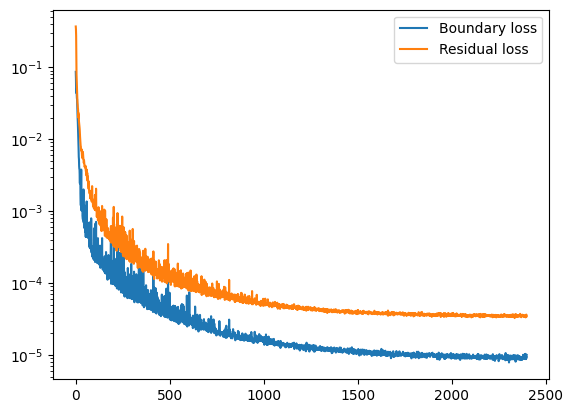

In [14]:
plt.plot(history['loss_bcs'], label='Boundary loss')
plt.plot(history['loss_res'], label='Residual loss')
plt.yscale('log')
plt.legend()
plt.show()

In [37]:
# Generate one test sample
length_scale = KERNEL_LEN
key = random.PRNGKey(12345)
P_test = 100
Nx = m
u_test, y_test, s_test = generate_test_data(key, 1, P_test)

# Predict
s_pred = filter_vmap(donet, in_axes=(0, 0))(u_test, y_test[:, ::-1])

# Generate an uniform mesh
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

# Compute the relative l2 error 
error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2)
print('Relative l2 errpr: {:.3e}'.format(error))

Relative l2 errpr: 2.585e-03


/tmp/ipykernel_869397/1740780088.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_869397/1740780088.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


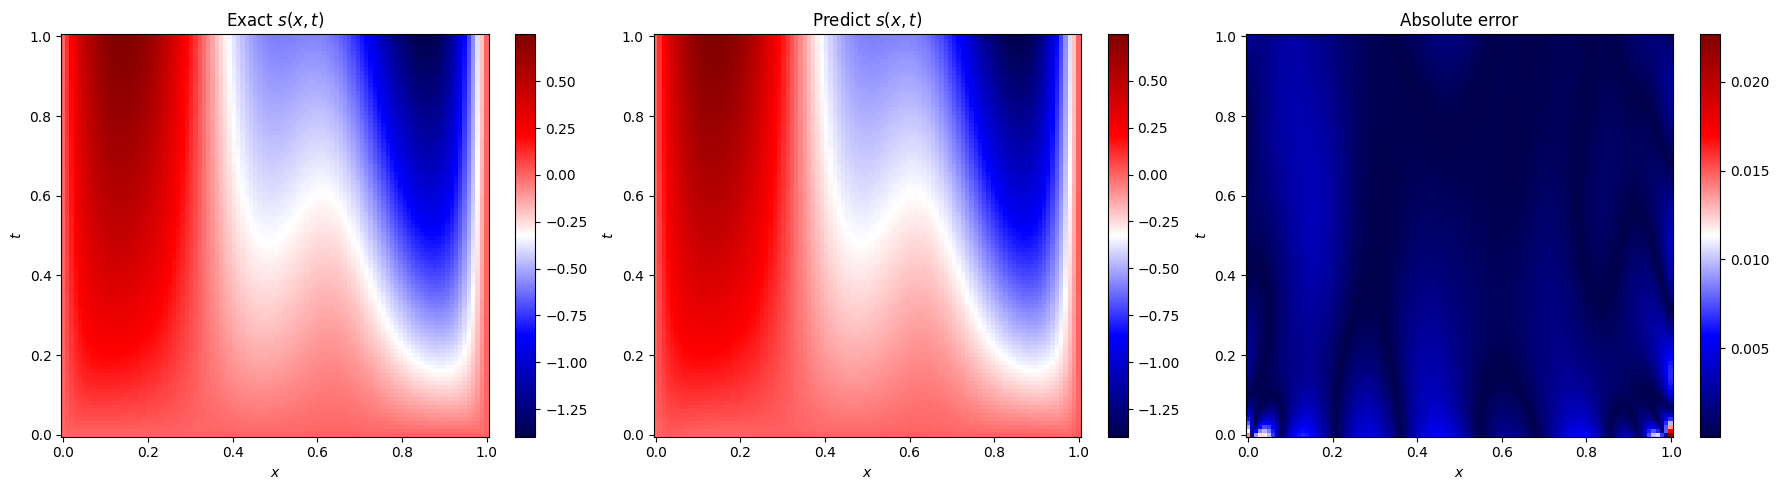

In [38]:
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(XX,TT, abs(S_pred - S_test), cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

Relative l2 errpr: 2.040e-03


/tmp/ipykernel_869397/4235011570.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_869397/4235011570.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


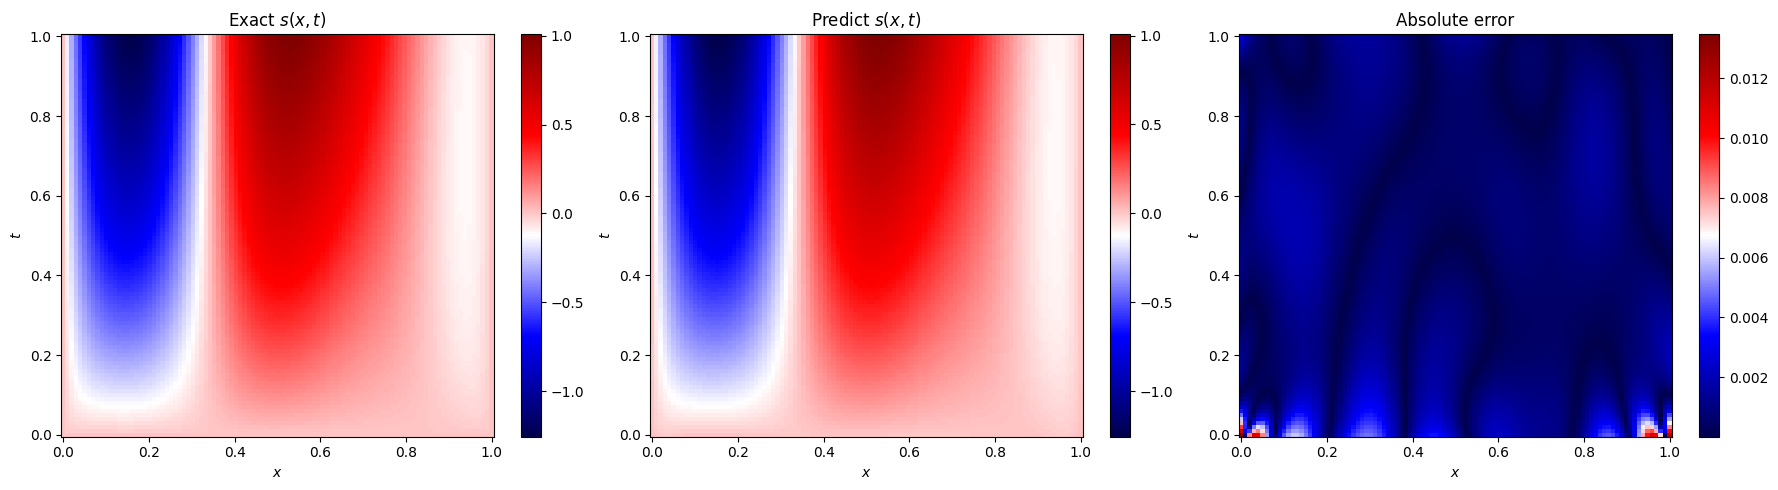

In [39]:
# Generate one test sample
key = random.PRNGKey(21)
P_test = 100
Nx = m
u_test, y_test, s_test = generate_test_data(key, 1, P_test)
length_scale = 0.2

# Predict
s_pred = filter_vmap(donet, in_axes=(0, 0))(u_test, y_test[:, ::-1])

# Generate an uniform mesh
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

# Compute the relative l2 error 
error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2)
print('Relative l2 errpr: {:.3e}'.format(error))
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(XX,TT, abs(S_pred - S_test), cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

Relative l2 errpr: 1.697e-02


/tmp/ipykernel_869397/2665307052.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_869397/2665307052.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


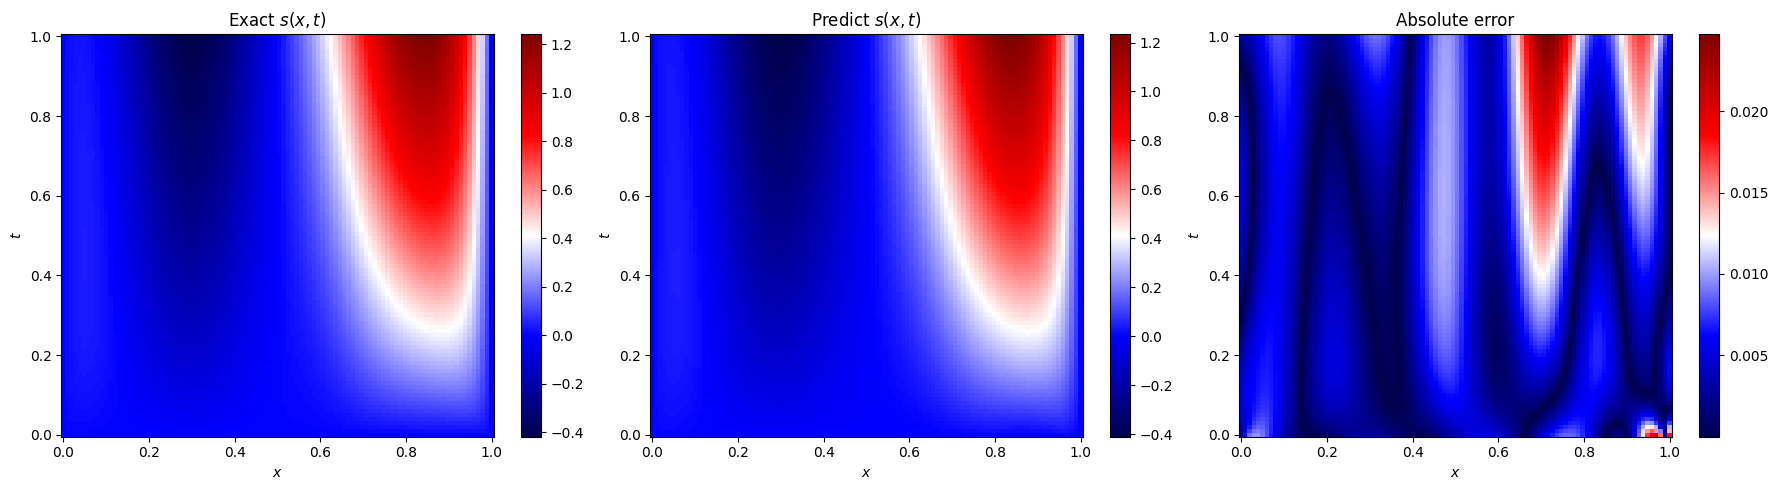

In [40]:
# Generate one test sample
length_scale = 0.15
key = random.PRNGKey(80)
P_test = 100
Nx = m
u_test, y_test, s_test = generate_test_data(key, 1, P_test)

# Predict
s_pred = filter_vmap(donet, in_axes=(0, 0))(u_test, y_test[:, ::-1])

# Generate an uniform mesh
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)
XX, TT = np.meshgrid(x, t)

# Grid data
S_pred = griddata(y_test, s_pred.flatten(), (XX,TT), method='cubic')
S_test = griddata(y_test, s_test.flatten(), (XX,TT), method='cubic')

# Compute the relative l2 error 
error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2)
print('Relative l2 errpr: {:.3e}'.format(error))
fig = plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.pcolor(XX,TT, S_test, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Exact $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,2)
plt.pcolor(XX,TT, S_pred, cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Predict $s(x,t)$')
plt.tight_layout()

plt.subplot(1,3,3)
plt.pcolor(XX,TT, abs(S_pred - S_test), cmap='seismic')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()